In [1]:
import torch
import torchvision

In [2]:
device = torch.device('mps')

In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
from torchvision import datasets

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


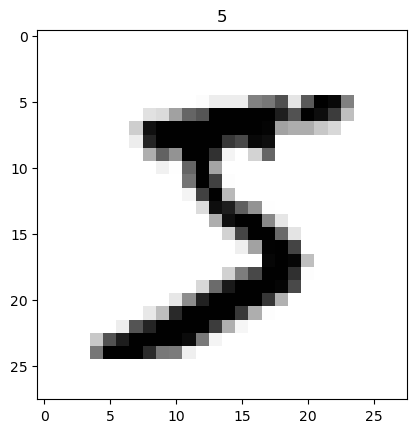

torch.Size([28, 28])


In [15]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray_r')
plt.title(f"{train_data.targets[0]}")
plt.show()
print(train_data.data[0].shape)

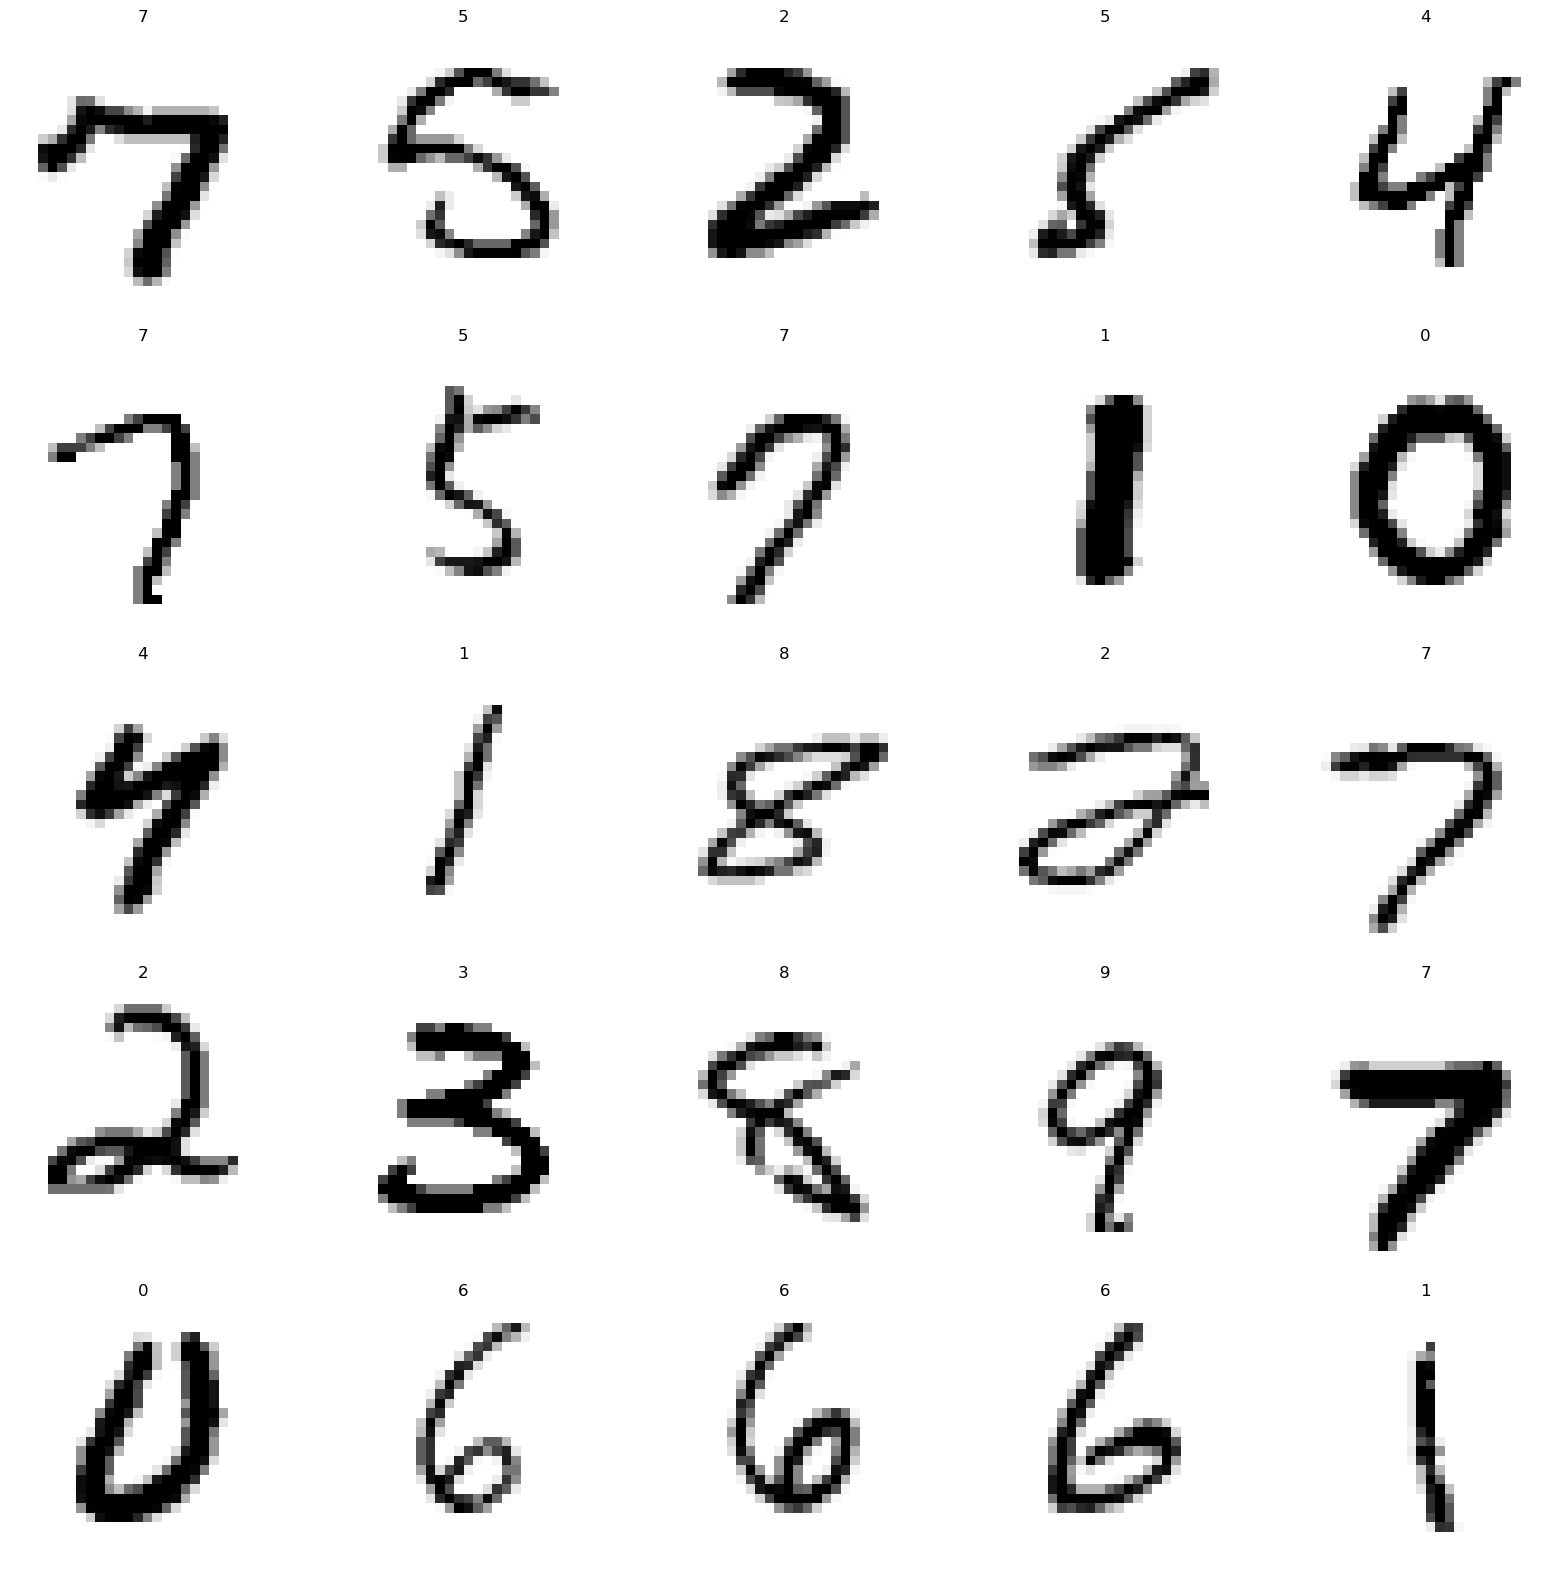

In [10]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray_r")
plt.show()

In [80]:
n_epochs = 14
train_batch_size = 64
test_batch_size = 1000
learning_rate = 1
gamma = 0.7

In [81]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

In [82]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # 26 x 26 x 16
        x = F.relu(x)
        x = self.conv2(x) # 24 x 24 x 32
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 12 x 12 x 32
        x = self.dropout1(x)
        x = torch.flatten(x, 1) # 4608
        x = self.fc1(x) # 128
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x) # 10
        output = F.log_softmax(x, dim=1)
        return output

In [83]:
def train(model, device, train_loader, optimizer, epoch, loss_func):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({"%.0f" % (100 * batch_idx / len(train_loader))}%)]\tLoss: {"%.6f" % loss.item()}')

In [84]:
def test(model, device, test_loader, loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f"\nTest set: Average loss: {'%.4f' % test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({'%.0f' % (100 * correct / len(test_loader.dataset))}%)\n")

In [85]:
from torch import optim

net = Net().to(device)
loss_func = F.nll_loss
optimizer = optim.Adadelta(net.parameters(), lr=learning_rate)

In [86]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, n_epochs + 1):
    train(net, device, train_loader, optimizer, epoch, loss_func)
    test(net, device, test_loader, loss_func)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311691
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.724388
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.630140
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.522697
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.530985
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.479775
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.260726
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.328232
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.347982
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.298444
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.168101
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.263497
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.109526
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.322485
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.151091
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.268422
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.259670
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.137558
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.217969
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.179697
Train Epoch: 1 [12800/60000 (